In [2]:
#Import various libraries for CNN based image classification

from torchsummary import summary
import PIL
import sys
import torch
from time import time
import torchvision
from PIL import Image
from torch.utils import data
from torch.autograd import Variable
import torchvision.transforms as transforms

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

# I have used Efficientnet3 pre-trained model for the classification task
#from efficientnet_pytorch import EfficientNet
import numpy as np 
import pandas as pd
import os
##Please copy and paste the path of the directory where the folder 'stat946winter2021' is present in the line below
BASE_PATH='/content/drive/MyDrive/data/'
train_dataset=pd.read_csv(os.path.join(BASE_PATH,'train_labels.csv'))
test_dataset=pd.read_csv(os.path.join(BASE_PATH,'test_labels.csv'))

PyTorch Version:  1.12.0+cu113
Torchvision Version:  0.13.0+cu113


In [3]:
train_dataset.head(3)


,File,Label
0,1329638562-58609.jpg,0
1,956062378-32202.jpg,0
2,118943055-21826.jpg,1


In [4]:
x = train_dataset['Label']
x.value_counts()/len(x)

0    0.897144
1    0.102856
Name: Label, dtype: float64

In [5]:
test_dataset.head(3)


,File
0,1002536285-58583.jpg
1,100738077-54097.jpg
2,100945025-10622.jpg


In [6]:
#Plot Images to take a look at the X-Ray images
#from PIL import Image
#from matplotlib.pyplot import imshow
#import matplotlib.pyplot as plt
#fig=plt.figure(figsize=(32, 32)) #Size of Figure
#columns = 3 #Columns in fig
#rows = 5 #Rows in Fig
#for i in range(1,rows*columns+1):
#    IMG_PATH=BASE_PATH+'train/'
#    img=Image.open(os.path.join(IMG_PATH,train_dataset.iloc[i][0]))
#    fig.add_subplot(rows, columns, i)
#    plt.imshow(img)
#plt.show()

In [7]:
# Inception
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [8]:
# Create a folder in the stat946winter2021 directory to save Weights

PATH_SAVE='./Weights/'
if(not os.path.exists(PATH_SAVE)):
    os.mkdir(PATH_SAVE)

In [9]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "/content/drive/MyDrive/data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "inception"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 100

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [10]:
val_acc_history = []
val_loss_history = []
train_acc_history = []
train_loss_history = []

In [11]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        t0 = time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            PRED = []
            A = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                #A = A.append(a_)
                #PRED = PRED.append(preds)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss) 
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print("Time ",round(time()-t0, 2),"s" )
        print()


    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [13]:
model.AuxLogits.fc = nn.Linear(768, num_classes)
model.fc = nn.Linear(2048, num_classes)

In [14]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [15]:
#Define the Dataset class to pair images and labels

class Dataset(data.Dataset):
    def __init__(self,csv_path,images_path,transform=None):
        self.train_set=pd.read_csv(csv_path) #Read The CSV and create the dataframe
        self.train_path=images_path #Images Path
        self.transform=transform # Augmentation Transforms
    def __len__(self):
        return len(self.train_set)
    
    def __getitem__(self,idx):
        file_name=self.train_set.iloc[idx][0] 
        label=self.train_set.iloc[idx][1]
        img=Image.open(os.path.join(self.train_path,file_name)) #Loading Image
        if self.transform is not None:
            img=self.transform(img)
        return img,label

In [16]:
# Prepare the dataset consisting of the training images and the corressponding labels

training_set_untransformed=Dataset(os.path.join(BASE_PATH,'train_labels.csv'),os.path.join(BASE_PATH,'train/'))
print(type(training_set_untransformed))

<class '__main__.Dataset'>


In [17]:
# Data augmentation and normalization for training
# Just normalization for validation
transform_train = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_valid = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

print("Initializing Datasets and Dataloaders...")

# Define a transform operation that applies transformations to an image

#transform_train = transforms.Compose([
#        transforms.Resize(input_size),
#        transforms.CenterCrop(input_size),
#    transforms.RandomHorizontalFlip(),
#    transforms.ToTensor(),
#    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
#])

#transform_train = transforms.Compose([transforms.Resize((299,299)),transforms.RandomApply([
#        torchvision.transforms.RandomRotation(10),
#        transforms.RandomHorizontalFlip()],0.7),
#		transforms.ToTensor()])

Initializing Datasets and Dataloaders...


In [18]:
# Split the new set into a training and validation dataset in the 80:20 ratio

train_size = int(0.8 * len(training_set_untransformed))
validation_size = len(training_set_untransformed) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(training_set_untransformed, [train_size,validation_size])

In [19]:
#Create transformed images from the training dataset such that the minority class is upsampled and the 
#resulting classes are equal in number in the new set

new_train_images=[]
for j in range (int(len(train_dataset)/5)):
    if train_dataset[j][1]==1:
        for k in range(9):
            transformed_image = transform_train(train_dataset[j][0])
            new_train_images.append((transformed_image,1))
    else:
        transformed_image = transform_train(train_dataset[j][0])
        new_train_images.append((transformed_image,0))

#Create transformed images from the training dataset such that the minority class is upsampled and the 
#resulting classes are equal in number in the new set

new_valid_images=[]      
for j in range (int(len(validation_dataset)/5)):
    if validation_dataset[j][1]==1:
        for k in range(9):
            transformed_image = transform_valid(validation_dataset[j][0])
            new_valid_images.append((transformed_image,1))
    else:
        transformed_image = transform_valid(validation_dataset[j][0])
        new_valid_images.append((transformed_image,0))

print(len(new_train_images),len(new_valid_images))  


4386 1090


In [20]:
image_datasets = {'train': new_train_images, 'val': new_valid_images}

# Create training and validation datasets
#image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders

In [21]:

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [23]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/100
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6597 Acc: 0.7704
val Loss: 0.4588 Acc: 0.8064
Time  30.15 s

Epoch 1/100
----------
train Loss: 0.4504 Acc: 0.8744
val Loss: 0.4177 Acc: 0.8330
Time  24.14 s

Epoch 2/100
----------
train Loss: 0.3965 Acc: 0.8876
val Loss: 0.3998 Acc: 0.8459
Time  24.59 s

Epoch 3/100
----------
train Loss: 0.3704 Acc: 0.8878
val Loss: 0.3737 Acc: 0.8633
Time  24.96 s

Epoch 4/100
----------
train Loss: 0.3451 Acc: 0.8990
val Loss: 0.3906 Acc: 0.8064
Time  25.29 s

Epoch 5/100
----------
train Loss: 0.3421 Acc: 0.8942
val Loss: 0.3900 Acc: 0.8083
Time  25.23 s

Epoch 6/100
----------
train Loss: 0.3371 Acc: 0.8981
val Loss: 0.3493 Acc: 0.8670
Time  25.21 s

Epoch 7/100
----------
train Loss: 0.3125 Acc: 0.9074
val Loss: 0.3214 Acc: 0.8780
Time  25.22 s

Epoch 8/100
----------
train Loss: 0.3035 Acc: 0.9081
val Loss: 0.3426 Acc: 0.8404
Time  25.19 s

Epoch 9/100
----------
train Loss: 0.3095 Acc: 0.9022
val Loss: 0.3365 Acc: 0.8706
Time  25.17 s

Epoch 10/100
----------
train Loss: 0.3100 

In [24]:
history_acc_train = []
for x in range(len(train_acc_history)):
  d = train_acc_history[x]
  d = d.cpu().detach().numpy()
  history_acc_train.append(d)

history_acc_val = []
for x in range(len(val_acc_history)):
  d = val_acc_history[x]
  d = d.cpu().detach().numpy()
  history_acc_val.append(d)

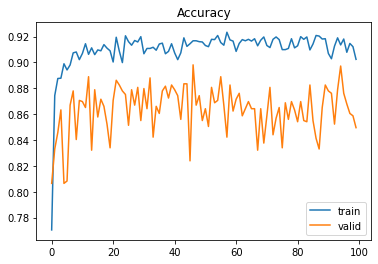

In [58]:
# Plot accuracy and loss histories
plt.plot(history_acc_train,label = 'train')
plt.plot(history_acc_val,label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

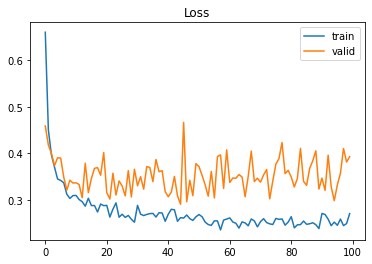

In [57]:
plt.plot(train_loss_history,label = 'train')
plt.plot(val_loss_history,label = 'valid')
plt.legend()
plt.title('Loss')
plt.show()

In [37]:
pip install scikit-learn==0.20.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 33.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.20.0 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.20.0 which is incompatible.


In [30]:
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master

import seaborn as sn
from torchviz import make_dot, make_dot_from_trace
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc, roc_auc_score


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-ot6ob8rp
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-ot6ob8rp
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4990 sha256=c8b7e96a8018ec4c21118f4b2da32e72957f019fb615e788b11f262c464fe0c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-ib_zqxhq/wheels/69/06/fd/652908d49c931cdcca96be3c727fb11ed777a3a62402210396
Successfully built torchviz


In [31]:
def test_eval(model,dataloaders, criterion):
  correcto = []
  corrects = 0.0
  Y_PRED = []
  Y_OBS = []
  Y_PROB = []
  model.eval()
  for inputs, labels in dataloaders['val']:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      _, preds = torch.max(outputs, 1)
      #probabilities = outputs[:, 1]
      probabilities = F.softmax(outputs, dim=1)[:, 1]

      # statistics
      #corrects += torch.sum(preds == labels.data)
      #cc = corrects.double()
      #correcto = correcto.append(cc)

      proba = probabilities.cpu().detach().numpy()
      Y_PROB = np.append(Y_PROB,proba, axis= 0)
      
      preds = preds.cpu().detach().numpy()
      Y_PRED = np.append(Y_PRED,preds, axis= 0)
      
      y_o = labels.data
      y_o = y_o.cpu().detach().numpy()
      Y_OBS = np.append(Y_OBS,y_o, axis= 0)

  return Y_PRED,Y_OBS,Y_PROB

In [32]:
# Train and evaluate
y_pred, y_obs, proba = test_eval(model_ft,dataloaders_dict, criterion)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [33]:
y_obs = y_obs[0:len(y_pred)]

In [34]:
confusion_matrix = pd.crosstab(y_pred, y_obs, rownames=['Predicho'], colnames=['Observado'])
confusion_matrix

Observado,0.0,1.0
Predicho,,
0.0,520,81
1.0,30,459


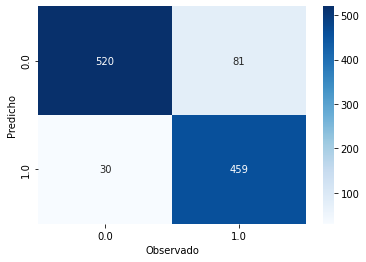

In [39]:
sn.heatmap(confusion_matrix, annot=True,cmap='Blues', fmt='g')
plt.show()

In [59]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_obs, proba)
roc_auc = auc(false_positive_rate, true_positive_rate)*100
roc_auc

94.87575757575758

In [60]:
sensibilidad = confusion_matrix[1][1]/ (confusion_matrix[1][0] + confusion_matrix[1][1])*100
especificidad =  confusion_matrix[0][0]/ (confusion_matrix[0][1] + confusion_matrix[0][0])*100
accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1])/len(y_pred)*100

tabla_df = (accuracy,sensibilidad,especificidad,roc_auc)
tabla_df
tabla = pd.DataFrame(tabla_df, columns= ['Resultados'])
tabla.index = ['Accuracy', 'Sensibilidad', 'Especificidad', 'AUC']
tabla

,Resultados
Accuracy,89.816514
Sensibilidad,85.000000
Especificidad,94.545455
AUC,94.875758


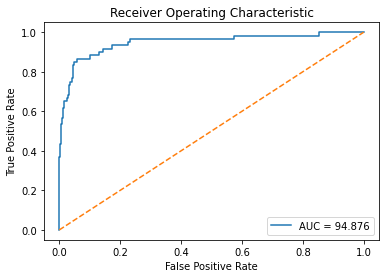

In [61]:
#plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate,label = 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],linestyle='--')

plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate' )
plt.show()

In [42]:
# Create a data frame from the sample submission file

submission=pd.read_csv(BASE_PATH+'sample_submission.csv')

In [43]:
# Check if the dataframe was created properly

submission.head(3)

,File,Label
0,90421068-27692.jpg,0
1,81279751-18187.jpg,0
2,106361457-9185.jpg,0


In [44]:
# Create a new data frame with file name and label as column headers

submission_csv=pd.DataFrame(columns=['File','Label'])

In [45]:
# Apply the same transformations on the test set as the training set so that the data distribution remains the same 

transform_test = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [46]:
# Define a function to predict an image

def predict_image(image):
    image_tensor = transform_test(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model_ft(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [47]:
# Predict test set images and add the predictions to the submission_csv dataframe

IMG_TEST_PATH=os.path.join(BASE_PATH,'test/')
for i in range(len(submission)):
    img=Image.open(IMG_TEST_PATH+submission.iloc[i][0])
    prediction=predict_image(img)
    submission_csv=submission_csv.append({'File': submission.iloc[i][0],'Label': prediction},ignore_index=True)
    if(i%10==0 or i==len(submission)-1):
        print('[',32*'=','>] ',round((i+1)*100/len(submission),2),' % Complete')

[ ================================ >]  0.25  % Complete
[ ================================ >]  2.75  % Complete
[ ================================ >]  5.25  % Complete
[ ================================ >]  7.75  % Complete
[ ================================ >]  10.25  % Complete
[ ================================ >]  12.75  % Complete
[ ================================ >]  15.25  % Complete
[ ================================ >]  17.75  % Complete
[ ================================ >]  20.25  % Complete
[ ================================ >]  22.75  % Complete
[ ================================ >]  25.25  % Complete
[ ================================ >]  27.75  % Complete
[ ================================ >]  30.25  % Complete
[ ================================ >]  32.75  % Complete
[ ================================ >]  35.25  % Complete
[ ================================ >]  37.75  % Complete
[ ================================ >]  40.25  % Complete
[ ================================ 

In [48]:
# Write the submision_csv dataframe to a csv file

submission_csv.to_csv('submission_epoch11_2.csv',index=False)

In [49]:
x = submission_csv['Label']
x.value_counts()/len(x)

0    0.53
1    0.47
Name: Label, dtype: float64